<a href="https://colab.research.google.com/github/huang-jiaming/ece421/blob/main/A1_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install tensorflow==1.14.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

def loadData():
    with np.load('/content/gdrive/My Drive/ECE421/notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


Mounted at /content/gdrive


In [3]:
def loss(w, b, x, y, reg):
    #flattens x (data) from an N * d * d matrix to an N * D matrix, D = d * d
    #x = x.reshape(np.shape(x)[0], np.shape(x)[1]*np.shape(x)[2])
    #N = np.shape(x)[0] #N is the number of samples
    #w = weight vector (initialize as 0)
    #b = bias vector (initialize as 0)
    #reg = regularization parameter (not sure)
    #y = class label (0, 1) for n-th training image (target)

    #calculates the logit z = w^Tx+b using the inner product <w, x> = w^Tx
    z = np.dot(x, w) + b

    #defines y_hat = sigma(z) = 1/(1+e^-z) in (0,1)
    y_hat = 1/(1 + np.exp(-z))

    #defines the cross-entropy loss L_CE
    L_CE = -np.mean((y)*np.log(y_hat) + (1-y)*np.log(1-y_hat))

    #defines the regularization term L_W
    L_W = reg/2 * (np.linalg.norm(w)**2)

    #aggregates the two terms into the loss function L
    L = L_CE + L_W

    return L

In [4]:
def grad_loss(w, b, x, y, reg):
    #x = x.reshape(np.shape(x)[0], np.shape(x)[1]*np.shape(x)[2])
    N = np.shape(y)[0] #N is the number of samples
    z = np.dot(x, w) + b
    y_hat = 1/(1 + np.exp(-z))
    grad_w = np.dot(np.transpose(x), (y_hat - y)) / N + reg*w
    grad_b = np.mean((y_hat-y))
    return grad_w, grad_b



In [5]:
def grad_descent(w, b, trainData, trainTarget, train_loss, valid_loss,
                 test_loss, train_acc, valid_acc, test_acc, validData, 
                 validTarget, testData, testTarget, alpha, epochs, reg, error_tol, acc):

    for i in range(epochs):
        grad_w, grad_b = grad_loss(w, b, trainData, trainTarget, reg)
        w_update = w - alpha * grad_w
        b_update = b - alpha * grad_b

        if(acc):
            train_loss.append(loss(w_update, b_update, trainData, trainTarget, reg))
            valid_loss.append(loss(w_update, b_update, validData, validTarget, reg))
            test_loss.append(loss(w_update, b_update, testData, testTarget, reg))
            train_acc.append(accuracy(w_update, b_update, trainData, trainTarget))
            valid_acc.append(accuracy(w_update, b_update, validData, validTarget))
            test_acc.append(accuracy(w_update, b_update, testData, testTarget))

            if(np.linalg.norm(w - w_update) < error_tol):
                return (w_update, b_update, train_loss, valid_loss, test_loss, 
                        train_acc, valid_acc, test_acc)
            else:
                w = w_update
                b = b_update

        elif(np.linalg.norm(w - w_update) < error_tol):
            return w_update, b_update
        else:
            w = w_update
            b = b_update
        
    if(acc):    
        return w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc
    else:
        return w, b


In [6]:
def accuracy(w, b, x, y):
    #x = x.reshape(np.shape(x)[0], np.shape(x)[1]*np.shape(x)[2])
    N = np.shape(y)[0] #N is the number of samples
    z = np.dot(x, w) + b
    y_hat = 1/(1 + np.exp(-z))
    acc = np.sum((y_hat >= 0.5) == y)/N
    return acc

In [7]:
def driver():

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.005, epochs = 5000, reg = 0, error_tol = 1e-7, acc = True)

    f = plt.figure(1)
    title = 'Training and Validation Loss with \u03B1 = 0.005 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(2)
    title = 'Training and Validation Accuracy with \u03B1 = 0.005 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.001, epochs = 5000, reg = 0, error_tol = 1e-7, acc = True)

    f = plt.figure(3)
    title = 'Training and Validation Loss with \u03B1 = 0.001 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(4)
    title = 'Training and Validation Accuracy with \u03B1 = 0.001 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.0001, epochs = 5000, reg = 0, error_tol = 1e-7, acc = True)

    f = plt.figure(5)
    title = 'Training and Validation Loss with \u03B1 = 0.0001 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(6)
    title = 'Training and Validation Accuracy with \u03B1 = 0.0001 and \u03BB = 0'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0.001)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.005, epochs = 5000, reg = 0.001, error_tol = 1e-7, acc = True)

    f = plt.figure(7)
    title = 'Training and Validation Loss with \u03B1 = 0.005 and \u03BB = 0.001'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(8)
    title = 'Training and Validation Accuracy with \u03B1 = 0.005 and \u03BB = 0.001'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0.1)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.005, epochs = 5000, reg = 0.1, error_tol = 1e-7, acc = True)

    f = plt.figure(9)
    title = 'Training and Validation Loss with \u03B1 = 0.005 and \u03BB = 0.1'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(10)
    title = 'Training and Validation Accuracy with \u03B1 = 0.005 and \u03BB = 0.1'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

    trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc = initializer(reg = 0.5)

    w, b, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = grad_descent(
        w, b, trainData, trainTarget, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc, validData, validTarget, testData, testTarget, alpha = 0.005, epochs = 5000, reg = 0.5, error_tol = 1e-7, acc = True)

    f = plt.figure(11)
    title = 'Training and Validation Loss with \u03B1 = 0.005 and \u03BB = 0.5'
    plt.title(title)  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_loss, 'r', range(5001), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()

    f = plt.figure(12)
    title = 'Training and Validation Accuracy with \u03B1 = 0.005 and \u03BB = 0.5'
    plt.title(title)  
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(5001), train_acc, 'r', range(5001), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()

    print('Training Accuracy: ', train_acc[5000])
    print('Validation Accuracy: ', valid_acc[5000])
    print('Test Accuracy: ', test_acc[5000])

In [8]:
def initializer(reg):

    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
    
    trainData = trainData.reshape(np.shape(trainData)[0], np.shape(trainData)[1]*np.shape(trainData)[2])
    validData = validData.reshape(np.shape(validData)[0], np.shape(validData)[1]*np.shape(validData)[2])
    testData = testData.reshape(np.shape(testData)[0], np.shape(testData)[1]*np.shape(testData)[2])

    w = np.random.normal(0, 0.5, (np.shape(trainData)[1], 1))

    b = 0

    train_loss = [loss(w, b, trainData, trainTarget, reg)]
    valid_loss = [loss(w, b, validData, validTarget, reg)]
    test_loss = [loss(w, b, testData, testTarget, reg)]
    train_acc = [accuracy(w, b, trainData, trainTarget)]
    valid_acc = [accuracy(w, b, validData, validTarget)]
    test_acc = [accuracy(w, b, testData, testTarget)]

    return trainData, validData, testData, trainTarget, validTarget, testTarget, w, b, reg, train_loss, valid_loss, test_loss, train_loss, train_acc, valid_acc, test_acc


In [9]:
def buildGraph(beta1, beta2, epsilon, alpha):
    w = tf.Variable(tf.truncated_normal([784, 1], mean = 0, stddev = 0.5, dtype = tf.float32))
    b = tf.Variable(tf.zeros(1))

    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 1])
    reg = tf.placeholder(tf.float32)

    logits = tf.matmul(x, w) + b

    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = y, logits = logits) + reg * tf.nn.l2_loss(w) #latter term returns half the l2 norm of w

    optimizer = tf.train.AdamOptimizer(alpha, beta1, beta2, epsilon).minimize(loss)

    return w, b, x, y, reg, loss, optimizer





In [10]:
def SGD(batch_size, beta1, beta2, epsilon, alpha, epochs):
    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
    tf.set_random_seed(421)
    trainData = trainData.reshape(np.shape(trainData)[0],np.shape(trainData)[1]*np.shape(trainData)[2])
    validData = validData.reshape(np.shape(validData)[0],np.shape(validData)[1]*np.shape(validData)[2])
    testData = testData.reshape(np.shape(testData)[0],np.shape(testData)[1]*np.shape(testData)[2])

    w, b, x, y, reg, loss, optimizer = buildGraph(beta1, beta2, epsilon, alpha)

    num_batches = np.shape(trainData)[0] // batch_size # rounds down number of batches so we get batches of same size (this is ok because we reshuffle the data)

    train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc = ([] for idx in range(6))

    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for i in range(epochs):
            index = np.arange(trainData.shape[0])
            np.random.shuffle(index)
            trainData = trainData[index, :]
            trainTarget = trainTarget[index]
            for j in range(num_batches):
                x_batch = trainData[j * batch_size : (j + 1) * batch_size, :]
                y_batch = trainTarget[j * batch_size : (j + 1) * batch_size, :]
                optimizer_something, loss_now, w_now, b_now = sess.run([optimizer, loss, w, b], feed_dict = {x: x_batch, y: y_batch, reg: 0})
            train_loss.append(sess.run(loss, feed_dict = {x: trainData, y: trainTarget, reg: 0}))
            valid_loss.append(sess.run(loss, feed_dict = {x: validData, y: validTarget, reg: 0}))
            test_loss.append(sess.run(loss, feed_dict = {x: testData, y: testTarget, reg: 0}))
            train_acc.append(accuracy(w_now, b_now, trainData, trainTarget))
            valid_acc.append(accuracy(w_now, b_now, validData, validTarget))
            test_acc.append(accuracy(w_now, b_now, testData, testTarget))

    return train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc

In [11]:
def driver2(batch_size, beta1, beta2, epsilon, alpha, epochs):
    train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc = SGD(batch_size, beta1, beta2, epsilon, alpha, epochs)

    plt.title('Loss with \u03B1 = {}, \u03BB = {}, \u03B2-1 = {}, \u03B2-2 = {}, batch size = {}, epochs = {}'.format(alpha, epsilon, beta1, beta2, batch_size, epochs))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')   
    plt.plot(range(epochs), train_loss, 'r', range(epochs), valid_loss, 'b')  
    plt.legend(["Training Loss" ,"Validation Loss"], loc = 'best')
    plt.show()
    print('Training Accuracy: ', train_acc[699])
    print('Validation Accuracy: ', valid_acc[699])
    print('Test Accuracy: ', test_acc[699])

    plt.title('Accuracy with \u03B1 = {}, \u03BB = {}, \u03B2-1 = {}, \u03B2-2 = {}, batch size = {}, epochs = {}'.format(alpha, epsilon, beta1, beta2, batch_size, epochs)) 
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')   
    plt.plot(range(epochs), train_acc, 'r', range(epochs), valid_acc, 'b')  
    plt.legend(["Training Accuracy" ,"Valid Accuracy"], loc = 'best')
    plt.show()
    print('Training Accuracy: ', train_acc[699])
    print('Validation Accuracy: ', valid_acc[699])
    print('Test Accuracy: ', test_acc[699])

In [14]:
def big_driver():
    #part 1
    driver()
    #q1 SGD first try
    driver2(batch_size = 500, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    #q3 batch sizes
    driver2(batch_size = 100, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 700, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 1750, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    #q4 hyperparameters
    driver2(batch_size = 500, beta1 = 0.95, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 500, beta1 = 0.99, beta2 = 0.999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 500, beta1 = 0.9, beta2 = 0.99, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 500, beta1 = 0.9, beta2 = 0.9999, epsilon = 1e-07, alpha = 0.001, epochs = 700)
    driver2(batch_size = 500, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-09, alpha = 0.001, epochs = 700)
    driver2(batch_size = 500, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-04, alpha = 0.001, epochs = 700)



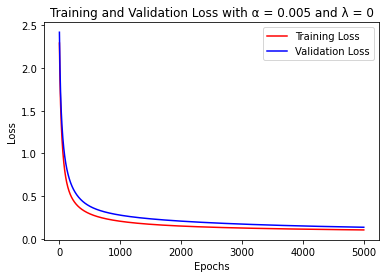

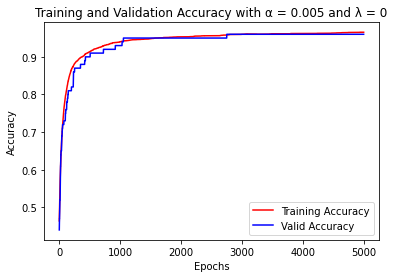

Training Accuracy:  0.9654285714285714
Validation Accuracy:  0.96
Test Accuracy:  0.9724137931034482


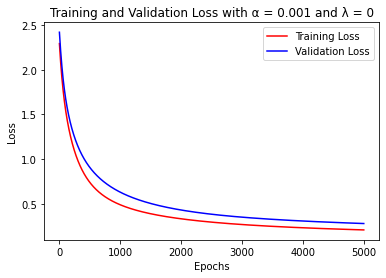

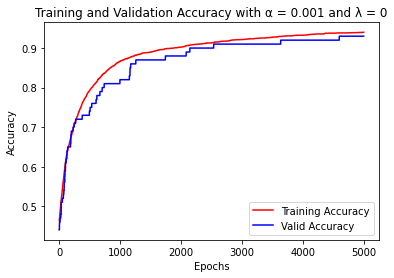

Training Accuracy:  0.94
Validation Accuracy:  0.93
Test Accuracy:  0.9655172413793104


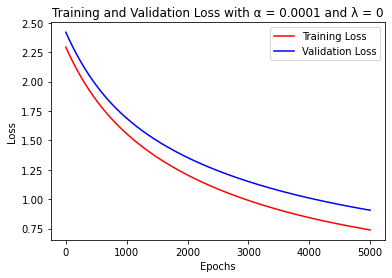

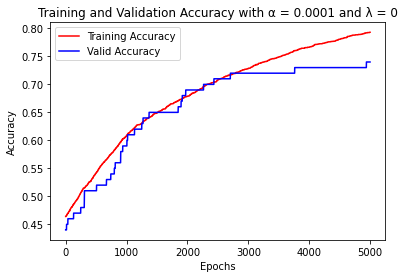

Training Accuracy:  0.7931428571428571
Validation Accuracy:  0.74
Test Accuracy:  0.8


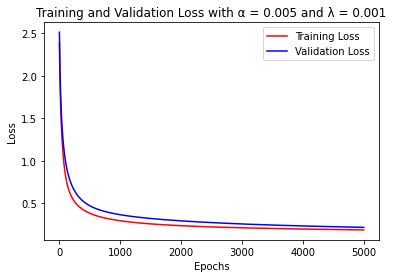

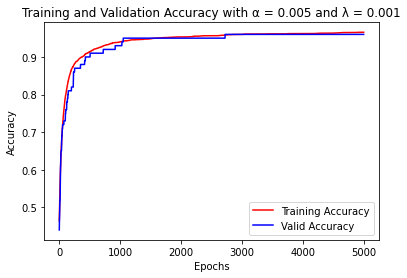

Training Accuracy:  0.9657142857142857
Validation Accuracy:  0.96
Test Accuracy:  0.9724137931034482


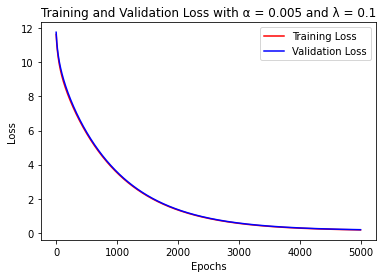

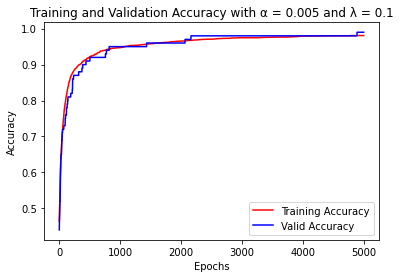

Training Accuracy:  0.9808571428571429
Validation Accuracy:  0.99
Test Accuracy:  0.9793103448275862


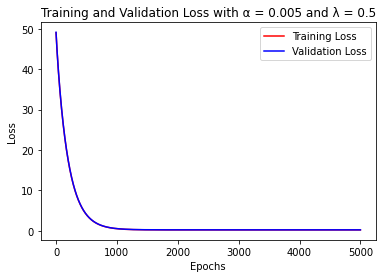

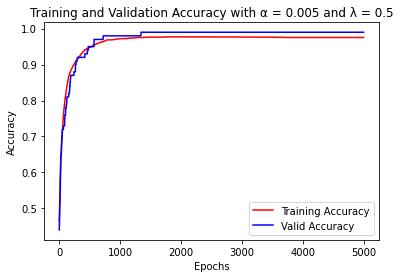

Training Accuracy:  0.9754285714285714
Validation Accuracy:  0.99
Test Accuracy:  0.9724137931034482


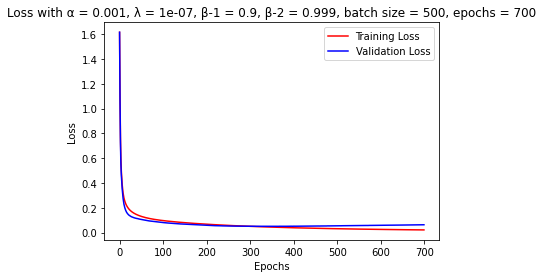

Training Accuracy:  0.9937142857142857
Validation Accuracy:  0.98
Test Accuracy:  0.9862068965517241


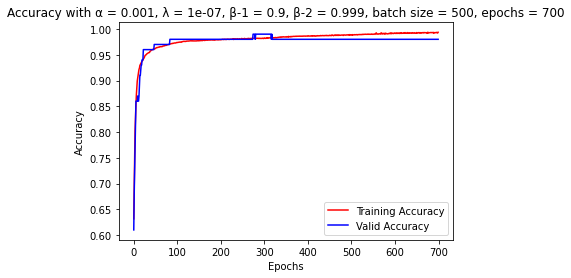

Training Accuracy:  0.9937142857142857
Validation Accuracy:  0.98
Test Accuracy:  0.9862068965517241


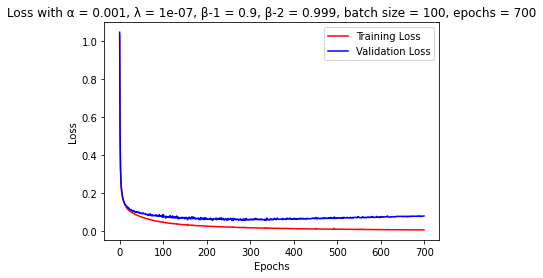

Training Accuracy:  0.9997142857142857
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


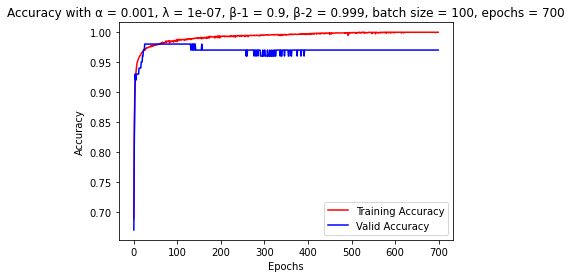

Training Accuracy:  0.9997142857142857
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


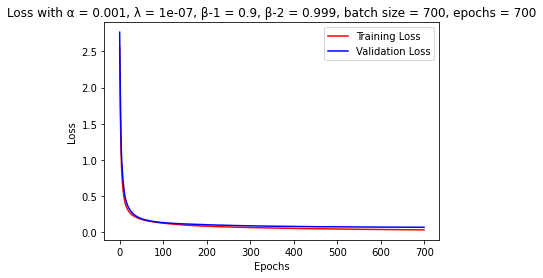

Training Accuracy:  0.9862857142857143
Validation Accuracy:  0.97
Test Accuracy:  0.9793103448275862


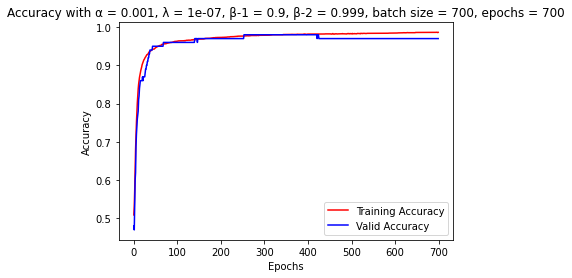

Training Accuracy:  0.9862857142857143
Validation Accuracy:  0.97
Test Accuracy:  0.9793103448275862


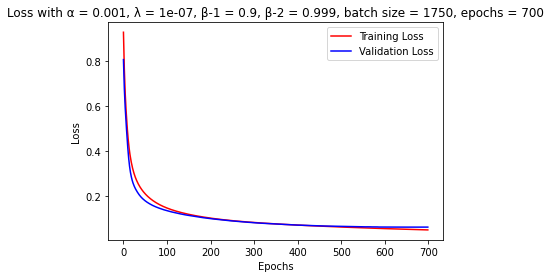

Training Accuracy:  0.982
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


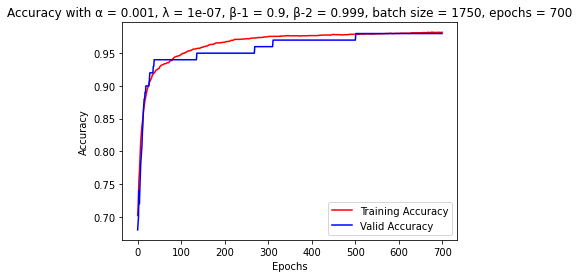

Training Accuracy:  0.982
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


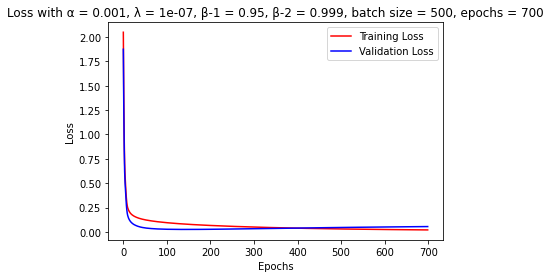

Training Accuracy:  0.994
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


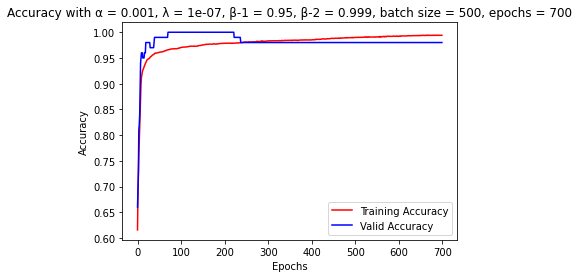

Training Accuracy:  0.994
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


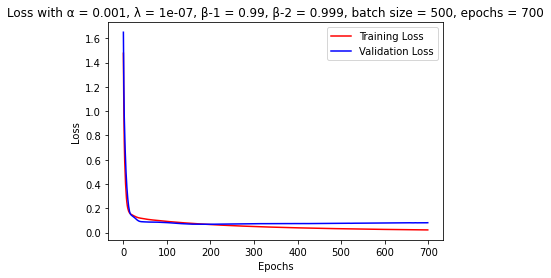

Training Accuracy:  0.9914285714285714
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


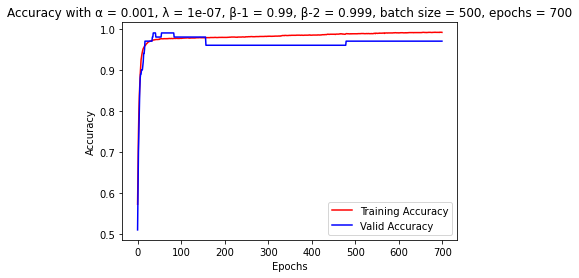

Training Accuracy:  0.9914285714285714
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


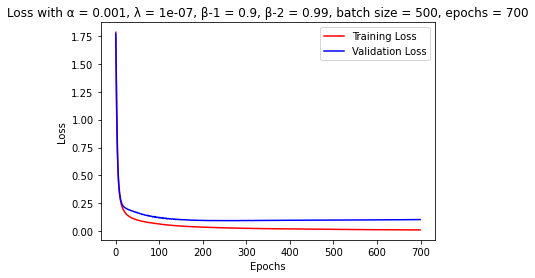

Training Accuracy:  0.9971428571428571
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


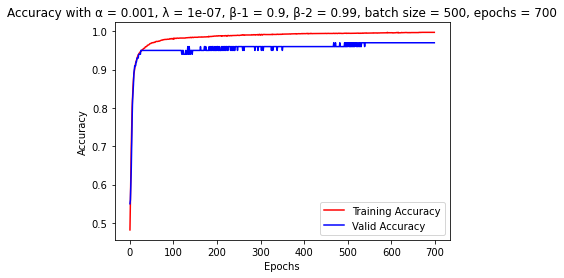

Training Accuracy:  0.9971428571428571
Validation Accuracy:  0.97
Test Accuracy:  0.9724137931034482


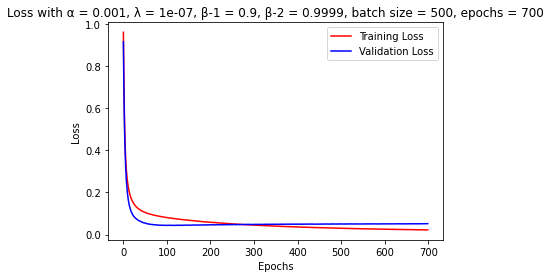

Training Accuracy:  0.9917142857142857
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


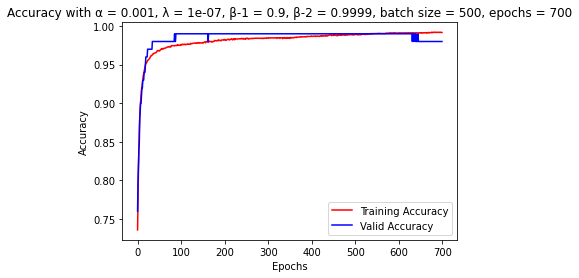

Training Accuracy:  0.9917142857142857
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


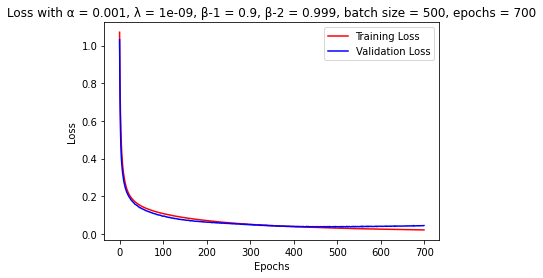

Training Accuracy:  0.9948571428571429
Validation Accuracy:  0.99
Test Accuracy:  0.9655172413793104


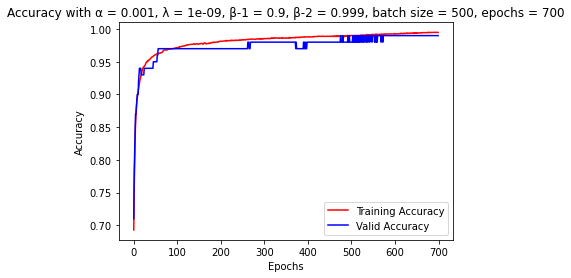

Training Accuracy:  0.9948571428571429
Validation Accuracy:  0.99
Test Accuracy:  0.9655172413793104


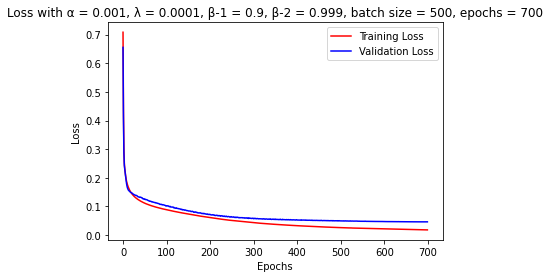

Training Accuracy:  0.994
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


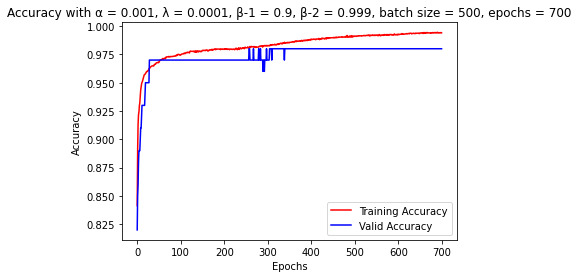

Training Accuracy:  0.994
Validation Accuracy:  0.98
Test Accuracy:  0.9793103448275862


In [15]:
big_driver()